In [1]:
%matplotlib inline

import cytoflow as flow

In [2]:
# In this instance, I have encoded the experimental conditions in the filenames.
# So, use glob to get the files and parse the conditions back out.

import glob, re
tubes = []

for f in glob.glob("*.fcs"):
    r = re.search("IP_(.*?)_Minutes_(.*?)\.fcs", f)
    ip = r.group(1)
    minutes = r.group(2)
    
    tube = flow.Tube(file = f, conditions = {"IP" : float(ip), "Minutes" : int(minutes)})
    tubes.append(tube)
    
ex = flow.ImportOp(tubes = tubes,
                   conditions = {"IP" : "float",
                                 "Minutes" : "int"},
                   events = 1000).apply()

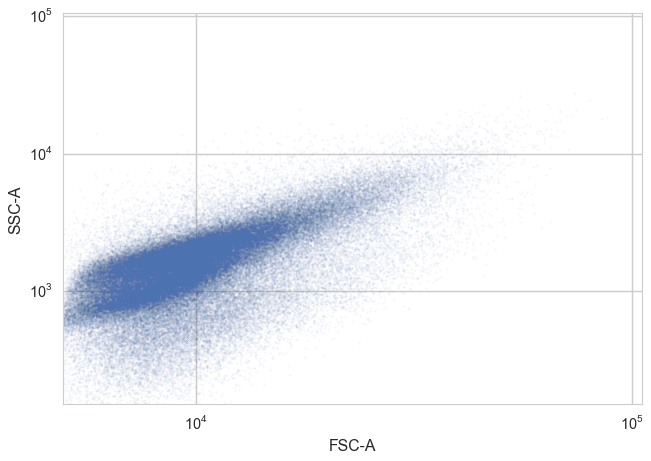

In [3]:
flow.ScatterplotView(xchannel = "FSC-A",
                     xscale = "log",
                     ychannel = "SSC-A",
                     yscale = "log").plot(ex, alpha = 0.05)

In [4]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex)
ex_gm = gm.apply(ex)


/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:340: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


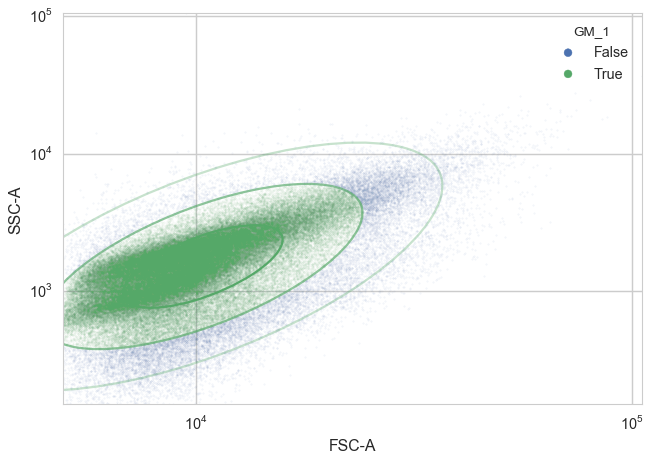

In [5]:
gm.default_view().plot(ex_gm, alpha = 0.05)

In [6]:
ex_stat = flow.ChannelStatisticOp(name = 'GFP',
                                  channel = 'FITC-A',
                                  function = flow.geom_mean,
                                  by = ['IP', 'Minutes'],
                                  subset = 'GM_1 == True').apply(ex_gm)

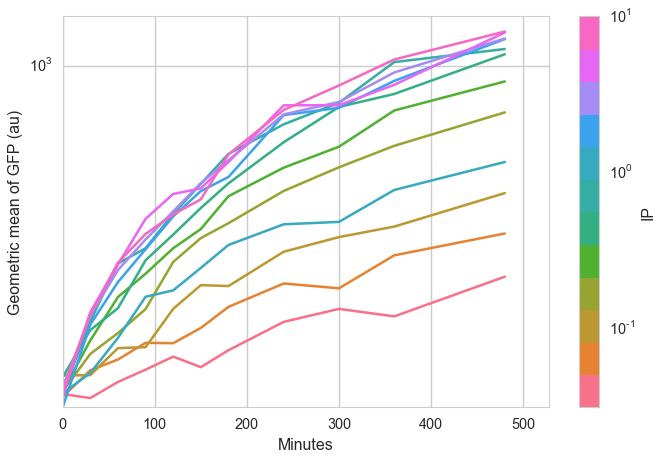

In [7]:
flow.Stats1DView(statistic = ('GFP', 'geom_mean'),
                 variable = 'Minutes',
                 scale = 'log',
                 huefacet = 'IP',
                 huescale = 'log').plot(ex_stat,
                                        ylabel = 'Geometric mean of GFP (au)')

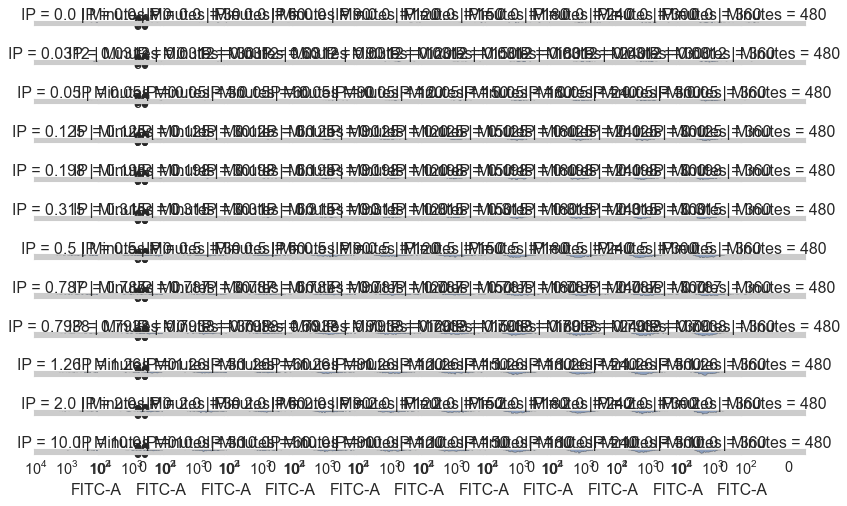

In [8]:
flow.HistogramView(channel = 'FITC-A',
                   xfacet = 'Minutes',
                   yfacet = 'IP',
                   scale = 'logicle',
                   subset = 'GM_1 == True').plot(ex_gm)

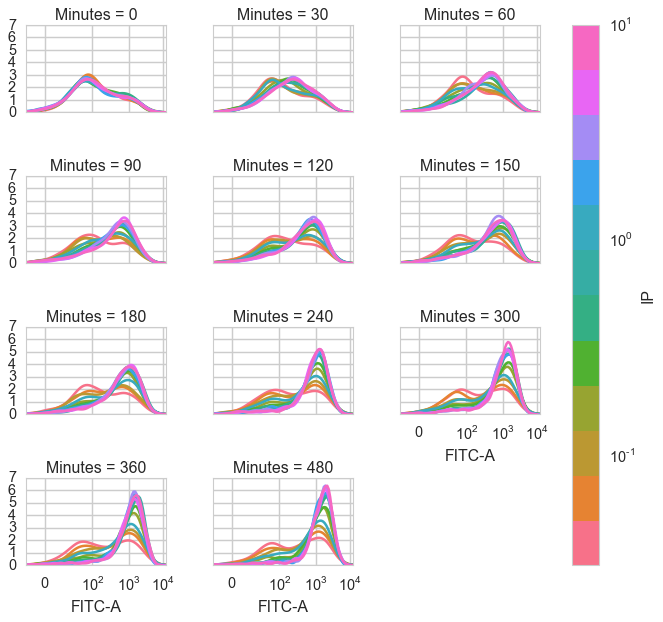

In [9]:
flow.Kde1DView(channel = 'FITC-A',
               xfacet = 'Minutes',
               huefacet = 'IP',
               scale = 'logicle',
               huescale = 'log',
               subset = 'GM_1 == True').plot(ex_gm, col_wrap = 3, shade = False)

In [10]:
gm_fitc = flow.GaussianMixtureOp(name = "GM_FITC",
                                 channels = ['FITC-A'],
                                 scale = {'FITC-A' : 'log'},
                                 by = ['IP', 'Minutes'],
                                 num_components = 2)
gm_fitc.estimate(ex_gm, subset = 'GM_1 == True')

In [11]:
ex_stat_2 = gm_fitc.apply(ex_gm)

In [12]:
ex_stat_2.statistics.keys()

dict_keys([('GM_FITC', 'sigma'), ('GM_FITC', 'proportion'), ('GM', 'correlation'), ('GM', 'mean'), ('GM_FITC', 'mean'), ('GM_FITC', 'interval'), ('GM', 'sigma'), ('GM', 'interval')])

In [13]:
ex_stat_2.statistics[('GM_FITC', 'proportion')]

IP       Minutes  Component
0.0000   0        1            0.725157
                  2            0.274843
         30       1            0.708553
                  2            0.291447
         60       1            0.691394
                  2            0.308606
         90       1            0.648845
                  2            0.351155
         120      1            0.617006
                  2            0.382994
         150      1            0.605596
                  2            0.394404
         180      1            0.691193
                  2            0.308807
         240      1            0.592657
                  2            0.407343
         300      1            0.558951
                  2            0.441049
         360      1            0.560241
                  2            0.439759
         480      1            0.486021
                  2            0.513979
0.0312   0        1            0.764041
                  2            0.235959
         30 

/home/brian/src/cytoflow/cytoflow/views/base_views.py:730: CytoflowViewWarning: Only one value for level Component; dropping it.


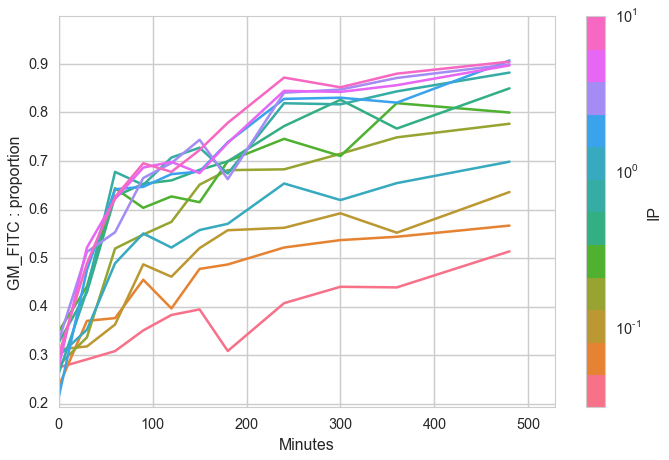

In [14]:
flow.Stats1DView(statistic = ("GM_FITC", "proportion"),
                 variable = "Minutes",
                 huefacet = "IP",
                 huescale = "log",
                 subset = "Component == 2").plot(ex_stat_2)

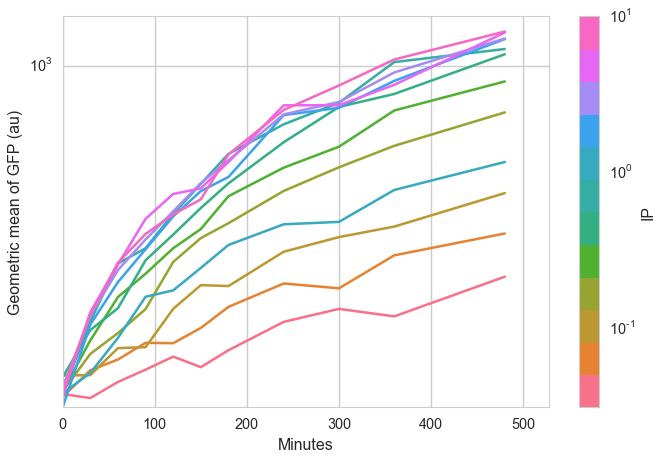

In [15]:
flow.Stats1DView(statistic = ('GFP', 'geom_mean'),
                 variable = 'Minutes',
                 scale = 'log',
                 huefacet = 'IP',
                 huescale = 'log').plot(ex_stat,
                                        ylabel = 'Geometric mean of GFP (au)')